In [1]:
import numpy as np
# import keras
import pandas as pd
import abc
# from os import *
import sys
import matplotlib.pyplot as plt
import random
# from gaussian_process import *
import csv
import glob
from gp_backend import load_dic
import os
import math
# from plots import plot_measurement
from sklearn.model_selection import KFold
from plotting import data_histogram

class DataGenerator():
    def __init__(self, batch_size=2048, dim=208, shuffle=True,
                 # no_sigmars=2, no_sigmaphis=2, no_sigmafs=2, no_sigmaerrs=2,
                 no_batches_ep = 4096,
                 # sigmafs=None, sigmaerrs=None, sigmalxs=None,
                 no_good_sensors=208,
                 exp_id='',
                 epoch_size = 32,
                 # shots=[],
                 n_splits=2,):
        self.batch_size = batch_size
        self.dim = dim
        
        # self.fs = []
        # self.xs = []
        # self.errs = []
        self.measurement_data = []
        # shots = get_shots()
        # self.shots = shots
        # file_names = os.listdir('./shot_data/sxr')
        self.n_splits = n_splits
        # print(exp_id)
        self.hp_dic = load_dic(exp_id + '/hp_params')
        # print(self.hp_dic)
        
        self.epoch_size = epoch_size
        self.generate_empty_buckets()
        
        self.sigma_fs = self.hp_dic['sigma_fs']
        self.sigma_xs = self.hp_dic['sigma_xs']
        self.sigma_errs = self.hp_dic['sigma_errs']
        self.name = 'main'
        # print(self.sigma_errs, type(self.sigma_errs))
        # exit(0)
        c = 0
        cs = 0
        # for counter, file_name in enumerate(file_names):
            # shot_id = file_name[5:10]
            # if int(shot_id) not in self.shots:# 30857, ]:#30294, 30310, 30357, 30372, 30376, 30400, 30405, 30406]:  #shots[:50] [30382,]  [30573, 30857]
            #     continue
            # c += 1
        # np_file = np.load('./shot_data/sxr/' + file_name)
        # measurement_data = np_file['data']#[:30]
        # measurement_err = np_file['err']
        errs = np.load(exp_id + '/reconstruction_sigma_errs.npy')
        fs = np.load(exp_id + '/reconstruction_sigma_fs.npy')
        xs = np.load(exp_id + '/reconstruction_sigma_xs.npy')
        # ts = np.load(exp_id + '/reconstruction_times.npy')
        measurement_data = np.load(exp_id + '/posterior_data_means.npy')
        single_mclasses = np.load(exp_id + '/single_multiclasses.npy')
        best_sigmas_grid = np.load(exp_id + '/best_sigmas_grid.npy')
        # print(measurement_data.shape, fs.shape, xs.shape, errs.shape, errs.shape)
        # assert measurement_data.shape[0] == errs.shape[0]
        # self.measurement_data.extend(measurement_data)
        data_histogram(best_sigmas_grid, self.sigma_fs, self.sigma_xs, self.sigma_errs, exp_id + '/data_histogram.pdf')
        # exit(0)
        for i in range(len(measurement_data)):
            # print(i, len(self.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
            cs += 1
            m = measurement_data[i]
            # print(m.shape)
            # exit(0)
            # m_err = measurement_err[i]
            # m_err[m_err!=float('inf')] = 1
            # m_err[m_err==float('inf')] = 0
            f = fs[i]
            x = xs[i]
            err = errs[i]
            # t = ts[i]
            
            # print(f)
            f_val = self.sigma_fs[np.argmax(f)]
            x_val = self.sigma_xs[np.argmax(x)]
            err_val = self.sigma_errs[np.argmax(err)]
            
            single_mclass = single_mclasses[i]
            arg_f = np.argwhere(f==1)[0][0]
            arg_x = np.argwhere(x==1)[0][0]
            arg_err = np.argwhere(err==1)[0][0]
            # print(np.expand_dims(np.ones(208)*err_val, axis=-1).shape)
            # print(m.shape)
            # exit(0)
            self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['m'].append(m) #arctan np.ones(208)*err_val
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['m_err'].append(m_err)
            self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['f'].append(f_val)
            self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['x'].append(x_val)
            self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['err'].append(err_val)
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['s&t'].append('#' + shot_id + '-' +  str(t))
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['s&t'].append('#' + shot_id + '-' +  str(t))
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['m'].append(m) #arctan np.ones(208)*err_val
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['m_err'].append(m_err)
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['f'].append(arg_f)
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['x'].append(arg_x)
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['err'].append(arg_err)
            # self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['s&t'].append('#' + shot_id + '-' +  str(t))
            self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['single_mclass'].append(single_mclass)
            self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['uid'].append(cs)
            
            # print(len(self.buckets[str(arg_f) + '-' +  str(arg_x)+ '-' +  str(arg_err)]['f']))
        print('Got', cs, ' data  samples. Hyperparameters were: f->', self.hp_dic['sigma_fs'], 'x', self.hp_dic['sigma_xs'], 'err', self.hp_dic['sigma_errs'])
        # self.shuffle()
        self.get_stats()
        # exit(0)
        kf = KFold(n_splits=self.n_splits)
        s = 0
        for k, v in self.buckets.items():
            # print('in)')
            if(len(v['m'])) != 0:
                # print('in)')
                data = self.buckets[k]['m']
                for fold_ind, (train_indexes, test_indexes) in enumerate(kf.split(data)):
                    # print(fold_ind, k, len(data), len(train_indexes), len(test_indexes))
                    # exit(0)
                    s += len(train_indexes)
                    s += len(test_indexes)
                    self.buckets[k]['split_inds_train'][fold_ind] = train_indexes
                    self.buckets[k]['split_inds_test'][fold_ind] = test_indexes
                    # print(train_indexes)
                    # print(test_indexes)
                    
        # exit(0)
        
    def get_stats(self,):
        print('------------------Printing stats for', self.name, 'generator------------------')
        s = 0
        print('f,x,err,count')
        for k in self.buckets.keys():
            s+=len(self.buckets[k]['m'])
            print(k, len(self.buckets[k]['m']))
        print('Total number of samples:', s)
        
    
    def generate_empty_buckets(self,):
        self.buckets = {}
        for sigma_f in range(len(self.hp_dic['sigma_fs'])):
            for sigma_x in range(len(self.hp_dic['sigma_xs'])):
                for sigma_err in range(len(self.hp_dic['sigma_errs'])):
                    # print(dict.fromkeys(np.arange(self.n_splits)))
                    self.buckets[str(sigma_f) + '-' +  str(sigma_x)+ '-' +  str(sigma_err)] = {'m': [], 'f': [], 'x': [],  'err': [], 's&t':[], 'm_err':[], 'single_mclass':[], 'uid':[],
                                                                     'split_inds_train': dict.fromkeys(np.arange(self.n_splits)),
                                                                     'split_inds_test':dict.fromkeys(np.arange(self.n_splits))}
    def shuffle(self,):
        # print(len(self.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
        for k, v in self.buckets.items():
            if(len(v['x'])) != 0:
                aux = list(zip(v['x'], v['err'], v['f'], v['m'], v['single_mclass'], v['uid']))
                random.shuffle(aux)
                # print(v['m'][0].shape)
                
                x, err, f, m, single_mclass, uid = zip(*aux) #t, m_err
                # print(type(m), len(m[0]), m)
                # exit(0)
                self.buckets[k]['x'] = list(x)
                self.buckets[k]['err'] = list(err)
                self.buckets[k]['f'] = list(f)
                self.buckets[k]['m'] = list(m)
                # self.buckets[k]['s&t'] = list(t)
                # self.buckets[k]['m_err']= list(m_err)
                self.buckets[k]['single_mclass']= list(single_mclass)
                # self.buckets[k]['uid']= list(uid)
        # print(len(self.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
        # exit(0)
                
    def __len__(self):
        return self.epoch_size
    
    def __getitem__(self, index):
        # start = index*self.batch_size
        # end = (index+1)*self.batch_size
        batch_in = {'m': [], 'm_err':[]}
        batch_out = {'x': [], 'err': [],'f': [], 'single_mclass':[]}
        batch_control = { 's&t': []}
        counter = 0
        # print(len(self.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
        # exit(0)
        while counter < self.batch_size:
            for k, v in self.buckets.items():
                if(len(v['x'])) != 0:
                    batch_in['m'].append(v['m'][0])
                    # exit(0)
                    v['m'].append(v['m'].pop(0))
                    batch_out['x'].append(v['x'][0])
                    batch_out['err'].append(v['err'][0])
                    batch_out['f'].append(v['f'][0])
                    batch_out['single_mclass'].append(v['single_mclass'][0])
                    v['x'].append(v['x'].pop(0))
                    v['err'].append(v['err'].pop(0))
                    v['f'].append(v['f'].pop(0))
                    v['single_mclass'].append(v['single_mclass'].pop(0))
                    # batch_control['s&t'].append(v['s&t'][0])
                    # v['s&t'].append(v['s&t'].pop(0))
                    # batch_in['m_err'].append(v['m_err'][0])
                    # v['m_err'].append(v['m_err'].pop(0))
                    counter += 1
                    
                    
        batch_in['m'] = np.expand_dims(np.asarray(batch_in['m']), axis=-1)[:self.batch_size]
        
        # batch_out['x'] = np.asarray(batch_out['x'])[:self.batch_size]
        # err = np.asarray(batch_out['err'])[:self.batch_size]
        # batch_out['err'] = err
        # batch_out['f'] = np.asarray(batch_out['f'])[:self.batch_size]
        
        batch_out['single_mclass'] = np.asarray(batch_out['single_mclass'])[:self.batch_size]
        batch_control['s&t'] = np.zeros(self.batch_size)
        # print(batch_in['m'].shape)
        # print(batch_out['single_mclass'].shape)
        # exit(0)
        return(batch_in['m'], batch_out['single_mclass']) #batch_control
        # print(batch_in['input'].shape)
        # print(batch_out['err'])
        # exit(0)
        # return (batch_in, batch_out['single_mclass'])
    
    def __iter__(self):
        return self
    
    def __next__(self):
        while True:
            for item in (self[i] for i in range(len(self))):
                yield item
            # print('Generator has gone through all its data, reshuffling...')
            self.shuffle()
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass
    
    def get_all_items(self):
        batch_in = {'m': [], 'm_err':[]}
        batch_out = {'x': [], 'err': [],'f': [], 'single_mclass':[]}
        batch_control = { 's&t': [], 'uid':[]}
        # counter = 0
        for k, v in self.buckets.items():
            if(len(v['x'])) != 0:
                batch_in['m'].extend(v['m'])
                # v['m'].append(v['m'].pop(0))
                batch_out['x'].extend(v['x'])
                batch_out['err'].extend(v['err'])
                batch_out['f'].extend(v['f'])
                batch_out['single_mclass'].extend(v['single_mclass'])
                # v['x'].append(v['x'].pop(0))
                # v['err'].append(v['err'].pop(0))
                # v['f'].append(v['f'].pop(0))
                # v['single_mclass'].append(v['single_mclass'].pop(0))
                batch_control['s&t'].extend(v['s&t'])
                # v['s&t'].append(v['s&t'].pop(0))
                batch_in['m_err'].extend(v['m_err'])
                # v['m_err'].append(v['m_err'].pop(0))
                # counter += 1
                batch_control['uid'].extend(v['uid'])
                    
        batch_in['m'] = np.expand_dims(np.asarray(batch_in['m']), axis=-1)#[:self.batch_size]
        batch_in['m_err'] = np.asarray(batch_in['m_err'])#[:self.batch_size]
        # print(batch_in['m'].shape, batch_in['m_err'].shape)
        # exit(0)
        # batch_in['input'] = np.moveaxis(np.asarray([batch_in['m'], batch_in['m_err']])[:self.batch_size], 0, -1)
        # batch_in['input'] = 
        batch_out['x'] = np.asarray(batch_out['x'])#[:self.batch_size]
        err = np.asarray(batch_out['err'])#[:self.batch_size]
        # ra = np.random.randn(self.batch_size)/10
        # err += err*ra
        # print(err)
        batch_out['err'] = err
        batch_out['f'] = np.asarray(batch_out['f'])#[:self.batch_size]
        batch_out['single_mclass'] = np.asarray(batch_out['single_mclass'])#[:self.batch_size]
        batch_control['s&t'] = np.asarray(batch_control['s&t'])#[:self.batch_size]
        batch_control['uid'] = np.asarray(batch_control['uid'])
        # return(batch_in, batch_out, batch_control)
        # print(batch_in['m'].shape)
        # print(batch_out['err'])
        # exit(0)
        return(batch_in['m'], batch_out['single_mclass'])
        # return (batch_in, batch_out, batch_control)
        
    
class TrainDataGenerator(DataGenerator):
    def __init__(self, k_fold, main_generator = None):
        self.hp_dic = main_generator.hp_dic
        self.n_splits = main_generator.n_splits
        self.generate_empty_buckets()
        self.epoch_size = main_generator.epoch_size
        self.batch_size = main_generator.batch_size
        self.name = 'train'
        # print(len(main_generator.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
        # exit(0)
        for k, v in self.buckets.items():
            # main_gen_len = len(main_generator.buckets[k]['m'])
            # frac = math.floor(0.8*main_gen_len)
            # print(k,'len', main_gen_len, frac)
            # print(k, k_fold)
            indices = main_generator.buckets[k]['split_inds_train'][k_fold]
            # print(indices)
            # v['m'] = main_generator.buckets[k]['m'][:frac]
            # v['f'] = main_generator.buckets[k]['f'][:frac]
            # v['x'] = main_generator.buckets[k]['x'][:frac]
            # v['err'] = main_generator.buckets[k]['err'][:frac]
            # v['s&t'] = main_generator.buckets[k]['s&t'][:frac]
            for key in ['m', 'f', 'x', 'err', 'single_mclass', 'uid']: #'s&t', 'm_err', 
                # print(key, k , k_fold)
                # print(len(np.asarray(main_generator.buckets[k][key])))
                # print(indices)
                
                v[key] = np.asarray(main_generator.buckets[k][key])[indices]
                # exit(0)
            # v['m'] = main_generator.buckets[k]['m'][indices]
            # v['f'] = main_generator.buckets[k]['f'][indices]
            # v['x'] = main_generator.buckets[k]['x'][indices]
            # v['err'] = main_generator.buckets[k]['err'][indices]
            # v['s&t'] = main_generator.buckets[k]['s&t'][indices]
        # print(len(self.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
        # print(len(main_generator.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
        # exit(0)
        self.shuffle()
        # self.get_stats()    
    
    def __str__(self,):
        return 'train'
    
        
class ValDataGenerator(DataGenerator):
    def __init__(self, k_fold, main_generator = None):
        self.hp_dic = main_generator.hp_dic
        self.n_splits = main_generator.n_splits
        self.generate_empty_buckets()
        self.epoch_size = main_generator.epoch_size
        self.batch_size = main_generator.batch_size
        self.name = 'validation'
        for k, v in self.buckets.items():
            # main_gen_len = len(main_generator.buckets[k]['m'])
            # frac = math.ceil(0.8*main_gen_len)
            indices = main_generator.buckets[k]['split_inds_test'][k_fold]
            
            # v['m'] = main_generator.buckets[k]['m'][frac:]
            # v['f'] = main_generator.buckets[k]['f'][frac:]
            # v['x'] = main_generator.buckets[k]['x'][frac:]
            # v['err'] = main_generator.buckets[k]['err'][frac:]
            # v['s&t'] = main_generator.buckets[k]['s&t'][frac:]
            for key in ['m', 'f', 'x', 'err', 'single_mclass', 'uid']: #'s&t', 'm_err', 
                v[key] = list(np.asarray(main_generator.buckets[k][key])[indices])
            # v['m'] = main_generator.buckets[k]['m'][indices]
            # v['f'] = main_generator.buckets[k]['f'][indices]
            # v['x'] = main_generator.buckets[k]['x'][indices]
            # v['err'] = main_generator.buckets[k]['err'][indices]
            # v['s&t'] = main_generator.buckets[k]['s&t'][indices]
            # print(indices)
        # print(len(self.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
        # exit(0)
        self.shuffle()
        # self.get_stats()  
    def __str__(self,):
        return 'test'

def main(args):
  
    # savedir=sys.argv[1]
    
    exp_id = './exps/' + args[1]
    # sigmafs, sigmaerrs, sigmaxs = load_prior_definition(exp_id)
    hp_dic = load_dic(exp_id + '/hp_params')
    sigma_fs = hp_dic['sigma_fs']
    sigma_xs = hp_dic['sigma_xs']
    sigma_errs = hp_dic['sigma_errs']
    # shots = list(hp_dic['shots'])#[:3]
    # shots=get_shots()[:-11]
    n_splits=2
    params_random = {'dim': 208,
                  'no_batches_ep': 256, 
                  'shuffle': True,
                  'exp_id':exp_id,
                  'batch_size': len(sigma_fs)*len(sigma_xs)*len(sigma_errs),
                  # 'shots':shots,
                  'n_splits':n_splits,
                }
    # print(params_random)
    # exit(0)
    
    
    mainGenerator = DataGenerator(**params_random)
    # print(len(mainGenerator.buckets[str(0) + '-' +  str(0)+ '-' +  str(0)]['m']))
    # exit(0)
    # k_fold = 0
    for k_fold in range(mainGenerator.n_splits):
        train_generator = TrainDataGenerator(k_fold, mainGenerator)
        train_gen = next(iter(train_generator))
        val_generator = ValDataGenerator(k_fold, mainGenerator)
        val_gen = next(iter(val_generator))
        # print(gen)
        # print('with the current batch size, each epoch should have', len(train_generator), 'steps')
        # pr_measurement_mean = np.zeros(208)
        
        count = 0
        for batch in train_gen:
            if count == 1:
                break
            samples = []
            samples_df = pd.DataFrame(columns=['input', 'f', 'x', 's&t'])
            # inputs, targets, control = batch
            inputs, targets = batch
            # ms = inputs['m']
            ms = inputs
            # single_mclass = targets['single_mclass']
            single_mclass = targets
            # print('len batch', len(batch))
            # for k in range(len(ms)):
            #     print(sh_time[k], fs[k], xs[k])
            # print(xs.shape)
            for k in range(len(ms)):
                # print(sh_time[k], fs[k], xs[k], errs[k], single_mclass[k])
                # print(fs[k], xs[k], errs[k], single_mclass[k])
                # print(single_mclass[k])
                # shot, time = sh_time[k].split('-')
                # plot_measurement(ms[k], m_err[k], 'no shot', 'no time')
                # break
                pass
            count += 1
            # print('finished batch')
            # print(errs[0])
            
        # count = 0    
        # for batch in val_gen:
        #     if count == 1:
        #         break
        #     samples = []
        #     samples_df = pd.DataFrame(columns=['input', 'f', 'x', 's&t'])
        #     inputs, targets, control = batch
        #     ms = inputs['m']
        #     print(ms.shape)
        #     # xs = targets['x']
        #     # fs = targets['f']
        #     # errs = targets['err']
        #     # m_err = inputs['m_err']
        #     # sh_time = control['s&t']
        #     single_mclass = targets['single_mclass']
        #     print('len batch', len(batch))
        #     # for k in range(len(ms)):
        #     #     print(sh_time[k], fs[k], xs[k])
        #     for k in range(len(ms)):
        #         # print(sh_time[k], fs[k], xs[k], errs[k], single_mclass[k])
        #         # shot, time = sh_time[k].split('-')
        #         # plot_measurement(ms[k], shot, time)
        #         break
        #     count += 1
        #     print('finished batch')
        #     # print(errs[0])
        # 
      

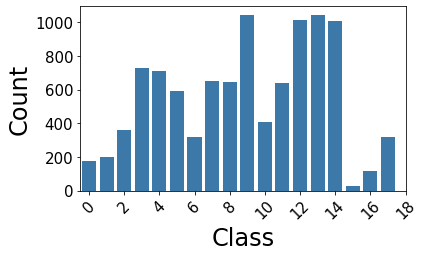

Got 10000  data  samples. Hyperparameters were: f-> [ 10  75 250] x [0.125 0.175 0.225] err [0.5 1. ]
------------------Printing stats for main generator------------------
f,x,err,count
0-0-0 174
0-0-1 1043
0-1-0 201
0-1-1 407
0-2-0 363
0-2-1 639
1-0-0 728
1-0-1 1015
1-1-0 710
1-1-1 1043
1-2-0 593
1-2-1 1010
2-0-0 318
2-0-1 28
2-1-0 649
2-1-1 115
2-2-0 644
2-2-1 320
Total number of samples: 10000


In [2]:
main(['', 'exp5'])